In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
!pip install --upgrade pip setuptools wheel
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
# !pip install pycombo
!pip install geopandas

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
# create the session
conf = SparkConf().set("spark.ui.port", "4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark

In [ ]:
#Ingest Safegraph Patterns
safegraph_patterns = spark.read.csv('/content/drive/MyDrive/SafeGraph/Data/weekly_sample.csv', header = True, sep = ",", escape = '"' )
safegraph_patterns.createOrReplaceTempView('safegraph_patterns')
# safegraph_patterns.count()

In [ ]:
safegraph_patterns.show(2)

+-------------------+---------------+-------------------+--------------------+--------------------+----------------+------------------+----------------+--------------------+------------+--------------------+--------------------+-------------------------+------------------+------------+--------------------+----------------------+-----------------------+
|           placekey|parent_placekey|safegraph_brand_ids|    date_range_start|      date_range_end|raw_visit_counts|raw_visitor_counts|   visits_by_day| visits_by_each_hour|     poi_cbg|   visitor_home_cbgs|visitor_daytime_cbgs|visitor_country_of_origin|distance_from_home|median_dwell|bucketed_dwell_times|related_same_day_brand|related_same_week_brand|
+-------------------+---------------+-------------------+--------------------+--------------------+----------------+------------------+----------------+--------------------+------------+--------------------+--------------------+-------------------------+------------------+------------+----

In [ ]:
# Function to extract some of the ARRAY or JSON columns for deeper analysis
from pyspark.sql.functions import udf, explode
from pyspark.sql.types import *
import json

def parser(element):
  return json.loads(element)

def parser_maptype(element):
  return json.loads(element, MapType(StringType(), IntegerType()))

jsonudf = udf(parser, MapType(StringType(), IntegerType()))

convert_array_to_dict_udf = udf(lambda arr: {idx: x for idx, x in enumerate(json.loads(arr))}, MapType(StringType(), IntegerType()))

def explode_json_column_with_labels(df_parsed, column_to_explode, key_col="key", value_col="value"):
  df_exploded = df_parsed.select("placekey", explode(column_to_explode)).selectExpr("placekey", "key as {0}".format(key_col), "value as {0}".format(value_col))
  return(df_exploded)

def explode_safegraph_json_column(df, column_to_explode, key_col="key", value_col="value"):
  df_parsed = df.withColumn("parsed_"+column_to_explode, jsonudf(column_to_explode))
  df_exploded = explode_json_column_with_labels(df_parsed, "parsed_"+column_to_explode, key_col=key_col, value_col=value_col)
  return(df_exploded)

def explode_safegraph_array_column(df, column_to_explode, key_col="index", value_col="value"):
  df_prepped = df.select("placekey", column_to_explode).withColumn(column_to_explode+"_dict", convert_array_to_dict_udf(column_to_explode))
  df_exploded = explode_json_column_with_labels(df_prepped, column_to_explode=column_to_explode+"_dict", key_col=key_col, value_col=value_col)
  return(df_exploded)

In [ ]:
# Extract some of the ARRAY- or JSON- columns in Patterns data for deeper analysis
popularity_by_day = explode_safegraph_array_column(safegraph_patterns, column_to_explode="visits_by_day", key_col="day_of_week", value_col="num_visits")
popularity_by_day.createOrReplaceTempView('visits_by_day')
popularity_by_day.show(7)

+-------------------+-----------+----------+
|           placekey|day_of_week|num_visits|
+-------------------+-----------+----------+
|22d-222@627-s26-tgk|          0|         0|
|22d-222@627-s26-tgk|          1|         1|
|22d-222@627-s26-tgk|          2|         0|
|22d-222@627-s26-tgk|          3|         3|
|22d-222@627-s26-tgk|          4|         1|
|22d-222@627-s26-tgk|          5|         0|
|22d-222@627-s26-tgk|          6|         0|
+-------------------+-----------+----------+
only showing top 7 rows



In [ ]:
popularity_by_hour = explode_safegraph_array_column(safegraph_patterns, column_to_explode="visits_by_each_hour", key_col="hour_of_day", value_col="num_visits")
popularity_by_hour.createOrReplaceTempView('visits_by_each_hour')
popularity_by_hour.show(5)

+-------------------+-----------+----------+
|           placekey|hour_of_day|num_visits|
+-------------------+-----------+----------+
|22d-222@627-s26-tgk|          0|         0|
|22d-222@627-s26-tgk|          1|         0|
|22d-222@627-s26-tgk|          2|         0|
|22d-222@627-s26-tgk|          3|         0|
|22d-222@627-s26-tgk|          4|         0|
+-------------------+-----------+----------+
only showing top 5 rows



In [ ]:
popularity_by_hour.groupBy('placekey').pivot('hour_of_day').agg(sum("num_visits")).show(5)

+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|           placekey|  0|  1| 10|100|101|102|103|104|105|106|107|108|109| 11|110|111|112|113|114|115|116|117|118|119| 12|120|121|122|123|124|125|126|127|128|129| 13|130|131|132|133|134|135|136|137|138|139| 14|140|141|142|143|144|145|146|147|148|149| 15|150|151|152|153|154|155|156|157|158|159| 16|160|161|1

In [ ]:
related_same_month_brand = explode_safegraph_json_column(safegraph_patterns, column_to_explode="related_same_month_brand", key_col="brand", value_col="shared_visit_index")
related_same_month_brand.createOrReplaceTempView('related_same_month_brand')

visitor_home_cbgs = explode_safegraph_json_column(safegraph_patterns, column_to_explode="visitor_home_cbgs", key_col="census_block_group", value_col="num_visits")
visitor_home_cbgs.createOrReplaceTempView('visitor_home_cbgs')

In [ ]:
weekly_area = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/weekly_and_core_with_area.csv')
weekly_area.head()

In [ ]:
b02.shape

(220333, 33)

In [ ]:
cbg_geo = gpd.read_file('/content/drive/MyDrive/SafeGraph/Data/cbg.geojson')
cbg_geo.head()

In [ ]:
!tar -xzvf "/content/drive/MyDrive/SafeGraph/Data/safegraph_open_census_data_2016.tar.gz" -C "/content/drive/MyDrive/SafeGraph/Data/"  

In [ ]:
census1 = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/safegraph_open_census_data_2016/metadata/cbg_geographic_data.csv') 
census1.head()

https://spark.apache.org/docs/latest/api/python/reference/index.html

## Census Data

https://www.census.gov/programs-surveys/acs/guidance/which-data-tool/table-ids-explained.html

https://docs.safegraph.com/docs/open-census-data

**02 Race** （Latinxs were 1.6 times more likely than whites to report their food access diminished by “a lot.” Asian respondents also reported significantly reduced ability to get food, with 54.8% reporting reduced access by “a lot” or “somewhat.” ）

08
Commuting (Journey to Work); Place of Work

14
School Enrollment

15
Educational Attainment; Undergraduate Field of Degree

16
Language Spoken at Home

17
Poverty Status

**19 Income** (Consumption level)

22
Food Stamps/Supplemental Nutrition Assistance Program (SNAP)

**23 Employment Status; Work Status Last Year** (Current consumption & future expectations)

27
Health Insurance Coverage



In [ ]:
census_des = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/metadata/cbg_field_descriptions.csv') 
census_des.head()

In [ ]:
census_des.shape

(7730, 10)

In [ ]:
# Race 
race_des = census_des[census_des.table_number.isin(['B02%s' % str(i).zfill(3) for i in range(1, 14)])&
           (census_des.field_level_1=='Estimate')&
           (census_des.table_title=='Race')][['table_id', 'field_level_5', 'field_level_6']]

NAME = []
ID = []
for i in race_des.index:
    if str(race_des.field_level_6[i]) != 'nan':
        NAME.append(race_des.field_level_6[i])
        ID.append(race_des.table_id[i])
    elif str(race_des.field_level_5[i]) != 'nan':
        NAME.append(race_des.field_level_5[i])
        ID.append(race_des.table_id[i])
    else:
        pass

race_dict = dict(zip(ID,NAME))
race_dict

{'B02001e10': 'Two races excluding Some other race and three or more races',
 'B02001e2': 'White alone',
 'B02001e3': 'Black or African American alone',
 'B02001e4': 'American Indian and Alaska Native alone',
 'B02001e5': 'Asian alone',
 'B02001e6': 'Native Hawaiian and Other Pacific Islander alone',
 'B02001e7': 'Some other race alone',
 'B02001e8': 'Two or more races',
 'B02001e9': 'Two races including Some other race'}

In [ ]:
b02 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b02.csv')
race = b02[['census_block_group'] + ID].rename(columns=race_dict)
race.head()

,census_block_group,Two races excluding Some other race and three or more races,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,Two races including Some other race
0,10010201001,57,613,60,0,0,0,0,57,0
1,10010201002,97,1072,92,0,2,0,0,97,0
2,10010202001,31,276,507,0,0,21,0,31,0
3,10010202002,25,483,610,0,0,0,6,25,0
4,10010203001,81,1866,557,0,32,5,233,81,0


In [ ]:
race.shape

(220333, 10)

In [ ]:
# Income
census_des[(census_des.table_number == 'B19013')&(census_des.field_level_1=='Estimate')]

,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
3030,B19013e1,B19013,Median Household Income In The Past 12 Months ...,Income Households Families Individuals,Households,Estimate,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,Households,Median household income in the past 12 months ...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
b19 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b19.csv')
income = b19[['census_block_group', 'B19013e1']].rename(columns={'B19013e1': 'MEDIAN HOUSEHOLD INCOME'})
income.head()

,census_block_group,MEDIAN HOUSEHOLD INCOME
0,10010201001,35703.0
1,10010201002,79000.0
2,10010202001,26500.0
3,10010202002,51042.0
4,10010203001,59048.0


In [ ]:
income.shape

(220333, 2)

In [ ]:
# Employment
census_des[census_des.table_id.isin(['B23025e4', 'B23025e5'])]

,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
4165,B23025e4,B23025,Employment Status For The Population 16 Years ...,Employment and Labor Force Status,Population 16 years and over,Estimate,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...,Population 16 years and over,Total,In labor force,Civilian labor force,Employed,NaN,NaN,NaN
4166,B23025e5,B23025,Employment Status For The Population 16 Years ...,Employment and Labor Force Status,Population 16 years and over,Estimate,EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...,Population 16 years and over,Total,In labor force,Civilian labor force,Unemployed,NaN,NaN,NaN


In [ ]:
c23 = pd.read_csv('/content/drive/MyDrive/SafeGraph/SafeGraph Open Census Data/safegraph_open_census_data_2019/data/cbg_b23.csv')
employment = c23[['census_block_group', 'B23025e4']].rename(columns={'B23025e4': 'Employed'}) #'B23025e5':'Unemployed'
employment.head()

,census_block_group,Employed
0,10010201001,311
1,10010201002,641
2,10010202001,253
3,10010202002,470
4,10010203001,1454


In [ ]:
employment.shape

(220333, 3)

In [ ]:
# merge the demographic features 
census_df = pd.concat([income, employment.iloc[:,1], race.iloc[:,1:]], axis=1)
census_df.head()

,census_block_group,MEDIAN HOUSEHOLD INCOME,Employed,Two races excluding Some other race and three or more races,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,Two races including Some other race
0,10010201001,35703.0,311,57,613,60,0,0,0,0,57,0
1,10010201002,79000.0,641,97,1072,92,0,2,0,0,97,0
2,10010202001,26500.0,253,31,276,507,0,0,21,0,31,0
3,10010202002,51042.0,470,25,483,610,0,0,0,6,25,0
4,10010203001,59048.0,1454,81,1866,557,0,32,5,233,81,0


In [ ]:
census_df.to_csv('/content/drive/MyDrive/SafeGraph/Data/census_feature.csv', index=False)

## Weekly Patterns

Hour of day

Day of week

Distance

Dwell time

In [ ]:
weekly_and_core = spark.read.options(header=True, escape='"').csv('/content/drive/MyDrive/SafeGraph/Data/weekly_sample.csv')
weekly_and_core.show(2)

+-------------------+---------------+-------------------+--------------------+--------------------+----------------+------------------+----------------+--------------------+------------+--------------------+--------------------+-------------------------+------------------+------------+--------------------+----------------------+-----------------------+
|           placekey|parent_placekey|safegraph_brand_ids|    date_range_start|      date_range_end|raw_visit_counts|raw_visitor_counts|   visits_by_day| visits_by_each_hour|     poi_cbg|   visitor_home_cbgs|visitor_daytime_cbgs|visitor_country_of_origin|distance_from_home|median_dwell|bucketed_dwell_times|related_same_day_brand|related_same_week_brand|
+-------------------+---------------+-------------------+--------------------+--------------------+----------------+------------------+----------------+--------------------+------------+--------------------+--------------------+-------------------------+------------------+------------+----

In [ ]:
weekly_and_core.count()

In [ ]:
# hour of day
weekly_and_core.select('visits_by_each_hour').show(5)

+--------------------+
| visits_by_each_hour|
+--------------------+
|[0,0,0,0,0,0,0,0,...|
|[0,0,0,0,0,0,0,0,...|
|[0,0,0,0,0,0,0,0,...|
|[0,0,0,0,0,0,0,0,...|
|[0,0,0,0,0,0,0,0,...|
+--------------------+
only showing top 5 rows



In [ ]:
# delete "[" "]"
df = weekly_and_core.withColumn("strip_1", regexp_replace("visits_by_each_hour", r"\[", "")).select("poi_cbg", "strip_1")
df = df.withColumn("strip_2", regexp_replace("strip_1", r"\]", "")).select("poi_cbg", "strip_2")
# split by ","
df = df.withColumn('key_and_value', concat(col('poi_cbg'),lit(","),col('strip_2')))
# to dataframe columns 
hourofday = df.select(split(df.key_and_value, ",")).rdd.flatMap(
                                          lambda x: x).toDF(schema=["poi_cbg"])
# convert to int 
hourofday = hourofday.select(col("poi_cbg"), *(col(c).cast("integer").alias(c) for c in hourofday.columns[1:]))
hourofday.show(2)

+------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|     poi_cbg| _2| _3| _4| _5| _6| _7| _8| _9|_10|_11|_12|_13|_14|_15|_16|_17|_18|_19|_20|_21|_22|_23|_24|_25|_26|_27|_28|_29|_30|_31|_32|_33|_34|_35|_36|_37|_38|_39|_40|_41|_42|_43|_44|_45|_46|_47|_48|_49|_50|_51|_52|_53|_54|_55|_56|_57|_58|_

In [ ]:
# get the dict of column names, for suming up 24*7 hours data into 24 hours
sum_dict = {}
for hour in range(24):
    sum_dict[hour] = []

for i, c in enumerate(hourofday.columns[1:]):
    if i<24:
        sum_dict[i].append(c)
    else:
        hour = i%24
        sum_dict[hour].append(c)
sum_dict.items()

dict_items([(0, ['_2', '_26', '_50', '_74', '_98', '_122', '_146']), (1, ['_3', '_27', '_51', '_75', '_99', '_123', '_147']), (2, ['_4', '_28', '_52', '_76', '_100', '_124', '_148']), (3, ['_5', '_29', '_53', '_77', '_101', '_125', '_149']), (4, ['_6', '_30', '_54', '_78', '_102', '_126', '_150']), (5, ['_7', '_31', '_55', '_79', '_103', '_127', '_151']), (6, ['_8', '_32', '_56', '_80', '_104', '_128', '_152']), (7, ['_9', '_33', '_57', '_81', '_105', '_129', '_153']), (8, ['_10', '_34', '_58', '_82', '_106', '_130', '_154']), (9, ['_11', '_35', '_59', '_83', '_107', '_131', '_155']), (10, ['_12', '_36', '_60', '_84', '_108', '_132', '_156']), (11, ['_13', '_37', '_61', '_85', '_109', '_133', '_157']), (12, ['_14', '_38', '_62', '_86', '_110', '_134', '_158']), (13, ['_15', '_39', '_63', '_87', '_111', '_135', '_159']), (14, ['_16', '_40', '_64', '_88', '_112', '_136', '_160']), (15, ['_17', '_41', '_65', '_89', '_113', '_137', '_161']), (16, ['_18', '_42', '_66', '_90', '_114', '_138'

two methods to sum 24*7 columns into each column of 24 hours

`expr()` or `reduce()`

```
for hour, cols_list in sum_dict.items():
    expression = '+'.join(cols_list)
    hourofday = hourofday.withColumn('hour_%d' % hour, expr(expression))

hourofday = hourofday.select(*["placekey"] + ["hour_%d" % i for i in range(24)])
hourofday = hourofday.groupby("placekey").sum()
hourofday.show(5)
```

https://stackoverflow.com/questions/53297872/how-can-i-sum-multiple-columns-in-a-spark-dataframe-in-pyspark

In [ ]:
from operator import add
from functools import reduce

# average columns in same hour of day
for hour, cols_list in sum_dict.items():
    hourofday = hourofday.withColumn("hour_%d" % hour, reduce(add, [col(x) for x in cols_list])/7)
# groupby cbg code & rename
hourofday_raw = hourofday.select(*["poi_cbg"] + ["hour_%d" % i for i in range(24)]).cache()
# cache for future using
hourofday = hourofday_raw.groupby("poi_cbg").mean().cache()

In [ ]:
exprs = {x: "sum" for x in hourofday_raw.columns[1:]}
hourofday_raw.groupBy("poi_cbg").agg(exprs).show(5)

+------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------+-------------------+-------------------+------------+-------------------+-----------+-------------------+-----------+-------------------+-------------------+-------------------+-----------+-------------------+-------------------+------------------+-------------------+
|     poi_cbg|       sum(hour_14)|        sum(hour_6)|       sum(hour_18)|      sum(hour_23)|       sum(hour_12)|       sum(hour_19)|        sum(hour_3)|        sum(hour_7)|sum(hour_22)|       sum(hour_11)|        sum(hour_2)|sum(hour_16)|       sum(hour_21)|sum(hour_8)|        sum(hour_4)|sum(hour_1)|       sum(hour_10)|       sum(hour_17)|        sum(hour_9)|sum(hour_5)|       sum(hour_20)|       sum(hour_15)|      sum(hour_13)|        sum(hour_0)|
+------------+-------------------+-------------------+-------------------+----------------

In [ ]:
def find_median(values_list):
    try:
        median = np.median(values_list) # get the median of values in a list in each row
        return round(float(median),2)
    except Exception:
        return None # if there is anything wrong with the given values

median_finder = udf(find_median, FloatType())

In [ ]:
hod_list = hourofday_raw.groupBy("poi_cbg").agg(collect_list("hour_0").alias("median(hour_0)"))
hod_list = hod_list.withColumn("median(hour_0)", median_finder("median(hour_0)")) 
hod_list.show(5)

+------------+--------------+
|     poi_cbg|median(hour_0)|
+------------+--------------+
|360850169012|          null|
|360470044002|          null|
|360470232002|          null|
|360610038007|          null|
|360610115001|          null|
+------------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import DataFrameStatFunctions as statFunc
hourofday_raw.groupby('poi_cbg').agg(statFunc(hourofday_raw.select(*hourofday_raw.columns[1:])).approxQuantile('hour_0', [0.5], 0.1)) # percent_rank; def percentile_approx(col, percentage, accuracy=10000):

In [ ]:
hourofday_raw.show(2)

+------------+-------------------+-------------------+------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------+-------------------+------------------+
|     poi_cbg|             hour_0|             hour_1|hour_2|             hour_3|             hour_4|             hour_5|             hour_6|            hour_7|             hour_8|             hour_9|            hour_10|           hour_11|           hour_12|            hour_13|            hour_14|           hour_15|           hour_16|           hour_17|            hour_18|           hour_19|            hour_20|hour_21|            hour_22|           hour_23|
+------------+-------------------+-------------------+------+---------------

In [ ]:
# num of CBGs
hourofday.count()

4708

In [ ]:
# day of week
df = weekly_and_core.withColumn("strip_1", regexp_replace("visits_by_day", r"\[", "")).select("poi_cbg", "strip_1")
df = df.withColumn("strip_2", regexp_replace("strip_1", r"\]", "")).select("poi_cbg", "strip_2")
df = df.withColumn('key_and_value', concat(col('poi_cbg'),lit(","),col('strip_2')))
dayofweek = df.select(split(df.key_and_value, ",")).rdd.flatMap(
              lambda x: x).toDF(schema=["poi_cbg"]+["day_%d" % i for i in range(7)])
dayofweek_raw = dayofweek.select(col("poi_cbg"), *(col(c).cast("integer").alias(c) for c in dayofweek.columns[1:]))
dayofweek = dayofweek_raw.groupby('poi_cbg').mean().cache()

In [ ]:
# dwell
dwell = weekly_and_core.select(col("poi_cbg"), col("median_dwell").cast("integer").alias("median_dwell"))
dwell = dwell.groupby('poi_cbg').mean()

# distance
distance = weekly_and_core.select(col("poi_cbg"), col("distance_from_home").cast("integer").alias("distance_from_home"))
distance = distance.groupby('poi_cbg').mean()

In [ ]:
weekly_df = hourofday.join(dayofweek,["poi_cbg"]).join(dwell, ['poi_cbg']).join(distance,['poi_cbg'])
weekly_df.show(2)

+------------+-------------------+-----------+-----------+-------------------+-----------+-----------+-----------+-----------+-----------+-----------+-------------------+-------------------+-------------------+------------------+------------+-------------------+------------+-------------------+-------------------+------------+-------------------+------------+------------+------------+----------+----------+----------+----------+----------+----------+----------+-----------------+-----------------------+
|     poi_cbg|        avg(hour_0)|avg(hour_1)|avg(hour_2)|        avg(hour_3)|avg(hour_4)|avg(hour_5)|avg(hour_6)|avg(hour_7)|avg(hour_8)|avg(hour_9)|       avg(hour_10)|       avg(hour_11)|       avg(hour_12)|      avg(hour_13)|avg(hour_14)|       avg(hour_15)|avg(hour_16)|       avg(hour_17)|       avg(hour_18)|avg(hour_19)|       avg(hour_20)|avg(hour_21)|avg(hour_22)|avg(hour_23)|avg(day_0)|avg(day_1)|avg(day_2)|avg(day_3)|avg(day_4)|avg(day_5)|avg(day_6)|avg(median_dwell)|avg(distanc

### KMeans Clustering 

**Features:**

hour of day

day of week

distance frome home

median dwell time

median household income

employment

race

https://spark.apache.org/docs/latest/ml-clustering.html

In [ ]:
census_df = spark.read.options(header=True).csv('/content/drive/MyDrive/SafeGraph/Data/census_feature.csv').withColumnRenamed("census_block_group","poi_cbg")
census_df.show(2)

+-----------+-----------------------+--------+-----------------------------------------------------------+-----------+-------------------------------+---------------------------------------+-----------+------------------------------------------------+---------------------+-----------------+-----------------------------------+
|    poi_cbg|MEDIAN HOUSEHOLD INCOME|Employed|Two races excluding Some other race and three or more races|White alone|Black or African American alone|American Indian and Alaska Native alone|Asian alone|Native Hawaiian and Other Pacific Islander alone|Some other race alone|Two or more races|Two races including Some other race|
+-----------+-----------------------+--------+-----------------------------------------------------------+-----------+-------------------------------+---------------------------------------+-----------+------------------------------------------------+---------------------+-----------------+-----------------------------------+
|10010201001|   

In [ ]:
census_df = census_df.select('poi_cbg', *(col(c).cast("float").alias(c) for c in census_df.columns[1:]))
census_df.printSchema()

root
 |-- poi_cbg: string (nullable = true)
 |-- MEDIAN HOUSEHOLD INCOME: float (nullable = true)
 |-- Employed: float (nullable = true)
 |-- Two races excluding Some other race and three or more races: float (nullable = true)
 |-- White alone: float (nullable = true)
 |-- Black or African American alone: float (nullable = true)
 |-- American Indian and Alaska Native alone: float (nullable = true)
 |-- Asian alone: float (nullable = true)
 |-- Native Hawaiian and Other Pacific Islander alone: float (nullable = true)
 |-- Some other race alone: float (nullable = true)
 |-- Two or more races: float (nullable = true)
 |-- Two races including Some other race: float (nullable = true)



In [ ]:
census_df.count()

220333

In [ ]:
weekly_df.count()

788

In [ ]:
feature_df = weekly_df.join(census_df, ['poi_cbg'], how='left')
feature_df.show(5)

+------------+-------------------+-----------+-------------------+-------------------+-------------------+-----------+-------------------+-------------------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------+-------------------+----------+----------+----------+----------+----------+----------+----------+-----------------+-----------------------+-----------------------+--------+-----------------------------------------------------------+-----------+-------------------------------+---------------------------------------+-----------+------------------------------------------------+---------------------+-----------------+-----------------------------------+
|     poi_cbg|        avg(hour_0)|avg(hour_1)|        avg(hour_2)|        avg(hour_3)|        avg(hour_4)|avg(

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# feature columns to vector
vecAssembler = VectorAssembler(inputCols=feature_df.columns[1:], 
                               outputCol="raw_features", handleInvalid='skip')

# crate normalizer
normalizer = MinMaxScaler(inputCol="raw_features", outputCol="features", min=0, max=1)

# create pipeline
pipeline_normalize = Pipeline(stages=[vecAssembler, normalizer])

# normalize data
normed_features = pipeline_normalize.fit(feature_df).transform(feature_df).cache()

In [ ]:
# feature columns to vector
vecAssembler = VectorAssembler(inputCols=feature_df.columns[1:], 
                               outputCol="features", handleInvalid='skip')

# crate normalizer
# normalizer = MinMaxScaler(inputCol="raw_features", outputCol="features", min=0, max=1)

# create pipeline
pipeline_normalize = Pipeline(stages=[vecAssembler]) #, normalizer

# normalize data
features = pipeline_normalize.fit(feature_df).transform(feature_df).cache()

In [ ]:
features.select('poi_cbg', 'features').show(2, truncate=False)

+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|poi_cbg     |raw_features                                                                                                                                                                                                                                                                                                                                                          |
+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
S = []
for i in range(2, 11):

    # Train a k-means model.
    kmeans = KMeans().setK(i).setSeed(0000)
    model = kmeans.fit(features)

    # Make predictions
    predictions = model.transform(features)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    S.append(silhouette)
    print("K = %d, Silhouette score = %s" % (i, str(silhouette)))

K = 2, Silhouette score = 0.7078404244915555
K = 3, Silhouette score = 0.8067122103907619
K = 4, Silhouette score = 0.7092664569599666
K = 5, Silhouette score = 0.7041727097842554
K = 6, Silhouette score = 0.6480837553620961
K = 7, Silhouette score = 0.6528376746412596
K = 8, Silhouette score = 0.6372202351330806
K = 9, Silhouette score = 0.6343292272435186
K = 10, Silhouette score = 0.6298716772771507


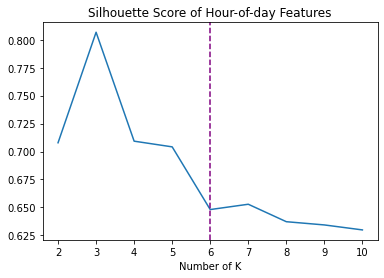

In [ ]:
plt.plot(range(2,11), S)
plt.axvline(x=6, color='purple', ls='--')
plt.title('Silhouette Score of Hour-of-day Features')
plt.xlabel('Number of K')
plt.show()

#### Try model K=6

In [ ]:
kmeans = KMeans().setK(6).setSeed(0000)
model = kmeans.fit(features)

# Make predictions
predictions = model.transform(features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
evaluator.evaluate(predictions)

0.6480837553620961

In [ ]:
cluster_count = predictions.select('prediction').groupby('prediction').count().toPandas()
cluster_count = cluster_count.sort_values(by='prediction')
cluster_count = cluster_count.set_index('prediction')
cluster_count

,count
prediction,
0,164
1,1
2,24
3,116
4,189
5,60


In [ ]:
cluster_cbg = predictions.select('poi_cbg', 'prediction').toPandas()
# cluster_cbg.poi_cbg = cluster_cbg.poi_cbg.astype('int64')
cluster_cbg.shape

(554, 2)

In [ ]:
cluster_cbg

,poi_cbg,prediction
0,360850169012,4
1,360470199004,4
2,360610006003,0
3,360470552003,4
4,360810245003,4
...,...,...
549,360050389002,0
550,360470037001,5
551,360470305001,3
552,360810277004,0


In [ ]:
cbg.shape

(6493, 9)

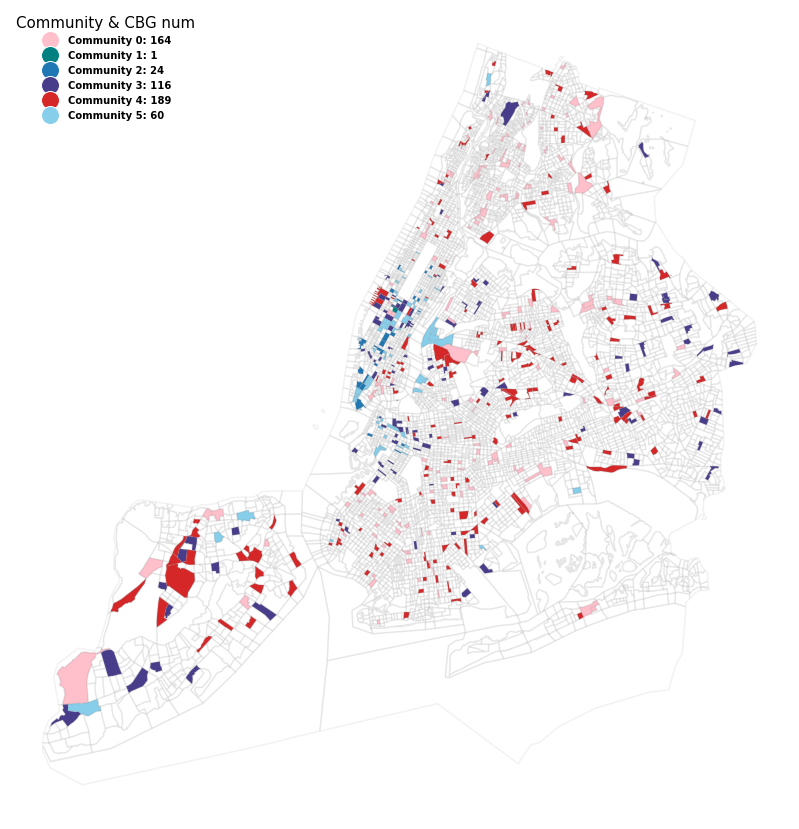

In [ ]:
cbg = gpd.read_file('/content/drive/MyDrive/SafeGraph/Data/nyc_cbgs.geojson')
cluster_geo = cluster_cbg.merge(cbg, left_on='poi_cbg', right_on='CensusBlockGroup', how='left')
cluster_geo = gpd.GeoDataFrame(cluster_geo)
# cluster_geo.head(2)
visualizePartitionShape(cluster_geo, 'prediction', 'poi_cbg', 6)

In [ ]:
predictions.columns

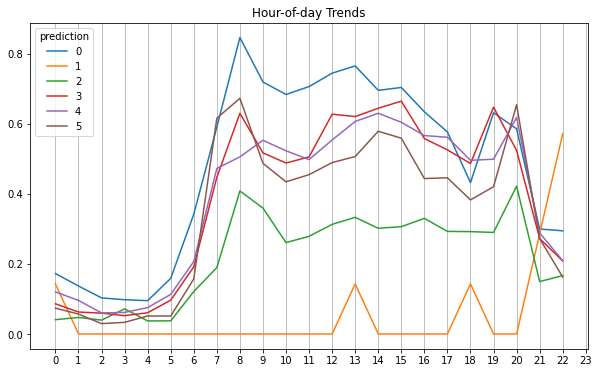

In [ ]:
hourofday_cluster = predictions.toPandas().iloc[:, :24].rename(columns=dict(zip(['avg(hour_%d)'%i for i in range(24)], range(24))))
hourofday_cluster = hourofday_cluster.merge(cluster_cbg, on='poi_cbg', how='outer')
hourofday_cluster = hourofday_cluster.groupby('prediction').mean() # groupby by labels
# scaler = preprocessing.MinMaxScaler() 
# scaled_values = scaler.fit_transform(hourofday_cluster) # normalize
# hourofday_cluster.loc[:,:] = scaled_values
# hourofday_cluster_normed = pd.DataFrame(values_scaled, index=hourofday_cluster.index, columns=range(24))
# hourofday_cluster
hourofday_cluster.T.plot(figsize=(10,6))
plt.title('Hour-of-day Trends')
plt.xticks(range(24))
plt.grid(axis='x')
plt.show()

In [ ]:
from sklearn.preprocessing import Normalizer

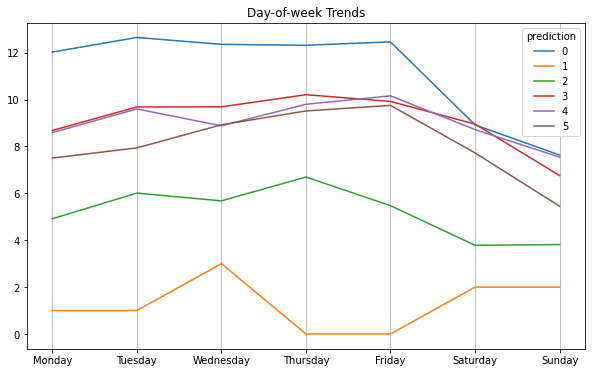

In [ ]:
dayofweek_cluster = dayofweek.toPandas()
dayofweek_cluster = dayofweek_cluster.merge(cluster_cbg, on='poi_cbg').rename(columns=dict(zip(['avg(day_%d)'%i for i in range(7)],
                                                  ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])))
# groupby cluster labels
dayofweek_cluster = dayofweek_cluster.groupby('prediction').mean()
# scaler = Normalizer() 
# scaled_values = scaler.fit_transform(dayofweek_cluster) 
# dayofweek_cluster.loc[:,:] = scaled_values
# dayofweek_cluster
dayofweek_cluster.T.plot(figsize=(10,6))
plt.title('Day-of-week Trends')
plt.grid(axis='x')
plt.show()

Text(0.5, 1.0, 'Dwell Time')

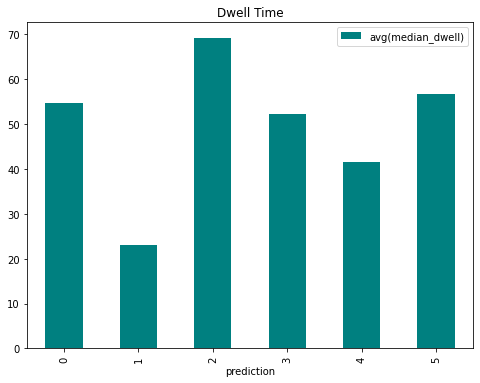

In [ ]:
dwell = weekly_and_core.select(col("poi_cbg"), col("median_dwell").cast("integer").alias("median_dwell"))
dwell = dwell.groupby('poi_cbg').mean().toPandas()
dwell_cluster = dwell.merge(cluster_cbg, on='poi_cbg')
dwell_cluster = dwell_cluster.groupby('prediction').mean()
# dwell_cluster
dwell_cluster.plot.bar(figsize=(8,6), color='teal')
plt.title('Dwell Time')

Text(0.5, 1.0, 'Travel Distance')

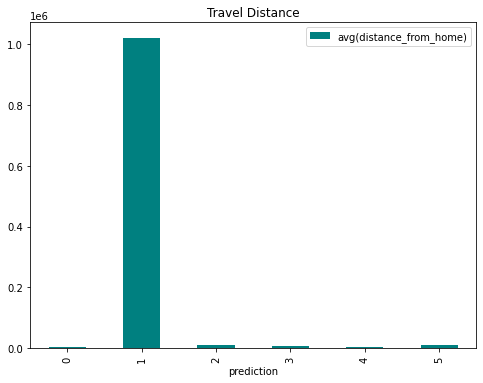

In [ ]:
distance = weekly_and_core.select(col("poi_cbg"), col("distance_from_home").cast("integer").alias("distance_from_home"))
distance = distance.groupby('poi_cbg').mean().toPandas()
distance_cluster = distance.merge(cluster_cbg, on='poi_cbg')
distance_cluster = distance_cluster.groupby('prediction').mean()
# distance_cluster
distance_cluster.plot.bar(figsize=(8,6), color='teal')
plt.title('Travel Distance')

In [ ]:
cluster_geo[cluster_geo.prediction==1]

,poi_cbg,prediction,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,MTFCC,geometry
337,360610125001,1,36,061,012500,1,360610125001,NY,New York County,G5030,"MULTIPOLYGON (((-73.98610 40.76229, -73.98405 ..."


In [ ]:
features.filter(features.poi_cbg=='360610125001').show(truncate=False)

+------------+-------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+-------------------+------------+------------+------------+------------+-------------------+------------+------------+------------------+------------------+------------+----------+----------+----------+----------+----------+----------+----------+-----------------+-----------------------+-----------------------+--------+-----------------------------------------------------------+-----------+-------------------------------+---------------------------------------+-----------+------------------------------------------------+---------------------+-----------------+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
weekly_and_core.filter(weekly_and_core.poi_cbg=='360610125001').show(truncate=False)

+-------------------+---------------+-------------------+-------------------------+-------------------------+----------------+------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------------------------------------------------+----------------------------------------------------+-------------------------+------------------+------------+---------------------------------------------------------------------+----------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
weekly_pdf = pd.read_csv('/content/drive/MyDrive/SafeGraph/Data/weekly_and_core.csv')
weekly_sub = weekly_pdf[['placekey', 'date', 'poi_cbg', 'raw_visit_counts',
                          'raw_visitor_counts', 'distance_from_home', 'median_dwell',
                         'top_category', 'sub_category']]
# merge cluster labels
weekly_cluster = weekly_sub.merge(cluster_cbg, on='poi_cbg', how='inner')
weekly_cluster.head()

,placekey,date,poi_cbg,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,top_category,sub_category,prediction
0,224-222@627-rw6-psq,2020-11-23,360050378003,2,2,NaN,6.0,Specialty Food Stores,Fish and Seafood Markets,0
1,224-222@627-rw6-psq,2020-11-30,360050378003,2,2,NaN,24.0,Specialty Food Stores,Fish and Seafood Markets,0
2,224-222@627-rw6-psq,2020-12-28,360050378003,6,6,4178.0,9.0,Specialty Food Stores,Fish and Seafood Markets,0
3,224-222@627-rw6-psq,2021-01-18,360050378003,7,6,1722.0,13.0,Specialty Food Stores,Fish and Seafood Markets,0
4,224-222@627-rw6-psq,2021-02-01,360050378003,6,6,6923.0,9.0,Specialty Food Stores,Fish and Seafood Markets,0


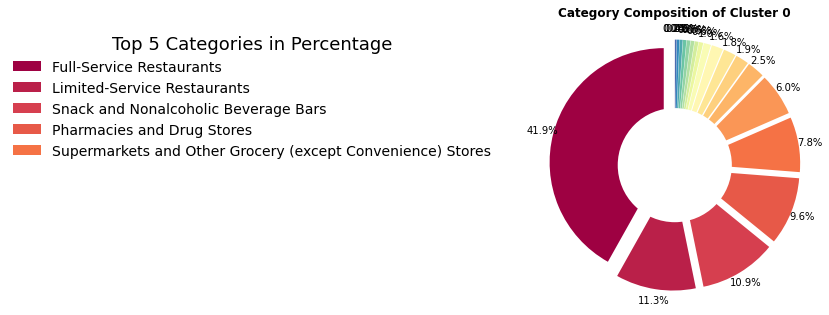

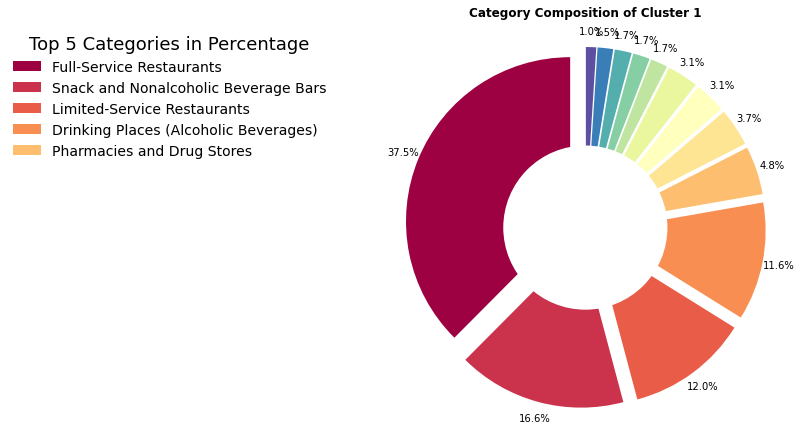

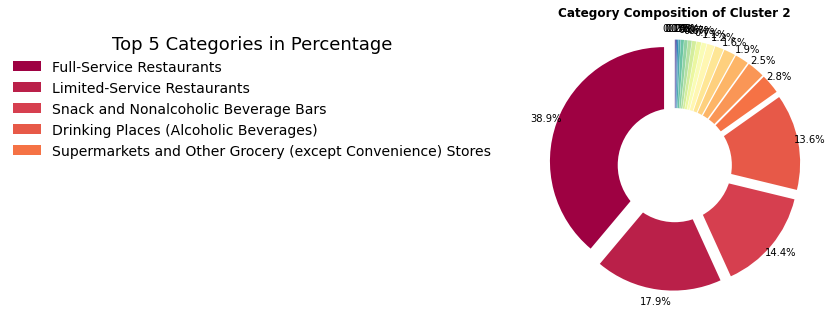

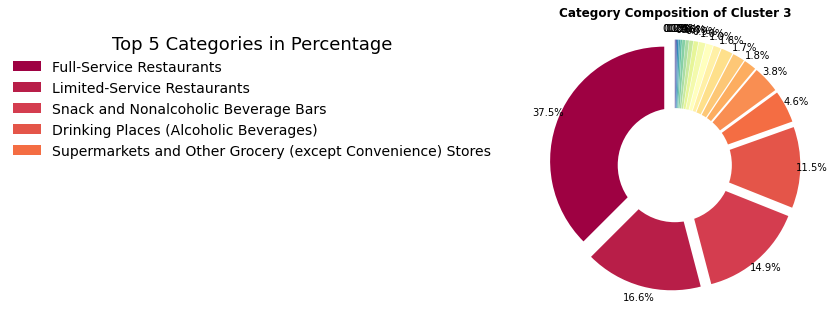

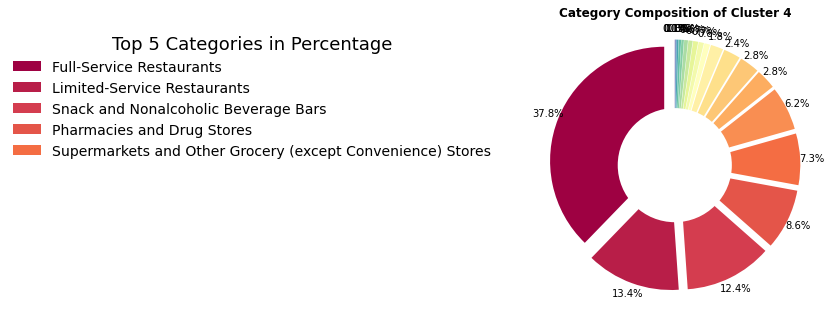

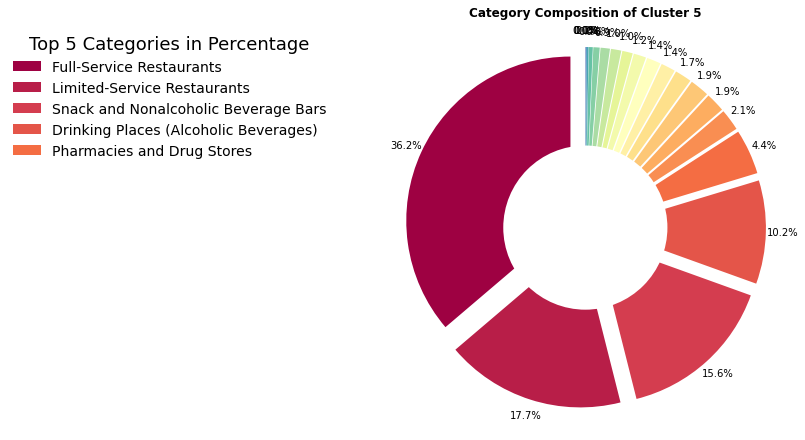

In [ ]:
 # set the figure and font size
# sns.set(rc={'figure.figsize':(10, 6), "axes.titlesize":18, "axes.labelsize":12})

 # category composition 
 for i in range(6):
    df =  weekly_cluster[weekly_cluster.prediction==i]
    percent_pie(df, 'sub_category', i, 'Spectral') #Set3  tab20b

In [ ]:
# compute the percentage of categories in each cluster
# then visualize as pie plot
# with top 5 cagegories in legend

def percent_pie(df, label, cluster, cmap_style='tab20c'):

    # percentage computing
    pct_df = df[[label]]
    pct_df['count'] = 1
    pct_df = pct_df.groupby(label).sum()
    pct_df['pct'] = pct_df['count'] / pct_df['count'].sum()
    pct_df = pct_df.sort_values(by='pct', ascending = False)

    # legend
    labels = pct_df.index[:5]
    # color
    number = len(pct_df.index)
    cmap = plt.get_cmap(cmap_style)
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    # explosion
    explode = (0.1,)*len(pct_df.index) 

    # plot
    plt.figure(figsize=(10,6))
    plt.pie(pct_df.pct.values, colors=colors, autopct='%1.1f%%', 
            startangle=90, pctdistance=1.1, explode = explode) 
    # draw circle
    centre_circle = plt.Circle((0,0),0.5,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # top 5 legend
    plt.legend(labels, title='Top 5 Categories in Percentage', 
               bbox_to_anchor =(-1.1, 0, 1, 1), title_fontsize=18, 
               loc=1, frameon=False, prop={'size':14}) 
    # hide plot frame
    plt.tight_layout()
    # title
    plt.title('Category Composition of Cluster %d' % cluster, 
              fontdict={'fontsize': rcParams['axes.titlesize'],
                        'fontweight' : 'bold',
                        'verticalalignment': 'baseline',
                        'horizontalalignment': 'center'})
    plt.show()

In [ ]:
cbg = gpd.read_file('/content/drive/MyDrive/SafeGraph/Data/nyc_cbgs.geojson')
cluster_geo = cluster_cbg.merge(cbg, left_on='poi_cbg', right_on='CensusBlockGroup', how='left')
cluster_geo = gpd.GeoDataFrame(cluster_geo)
# cluster_geo.head(2)
visualizePartitionShape(cluster_geo, 'prediction', 'poi_cbg', 6)

,poi_cbg,prediction,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,MTFCC,geometry
0,360850169012,0,36,085,016901,2,360850169012,NY,Richmond County,G5030,"MULTIPOLYGON (((-74.10707 40.61505, -74.10619 ..."
1,360810838003,0,36,081,083800,3,360810838003,NY,Queens County,G5030,"MULTIPOLYGON (((-73.82365 40.67104, -73.82308 ..."


In [ ]:
# function for visualizing communities 
from matplotlib.lines import Line2D 

def visualizePartitionShape(gdf, label, field_id, K, plttitle=''):
    
    fig, ax =  plt.subplots(figsize=(15, 15))
    cbg.boundary.plot(color='grey', alpha=0.1, ax=ax)
    colors=['pink','teal','tab:blue','darkslateblue','tab:red','skyblue','gold','tab:purple','gray','brown','seagreen','wheat']

    for c in range(K): # for each cluster
        gdf.geometry.loc[gdf[label]==c].plot(color=colors[c], ax=ax)
    
    count_cbg = gdf[[label, field_id]].groupby(label).count()
    legend_elements = [Line2D([0], [0], color='w', marker='o', label='Community %d: %d'%(i, count_cbg.poi_cbg[i]), markersize=18, markerfacecolor=colors[i]) for i in range(K)]

    ax.set_axis_off()
    ax.legend(handles=legend_elements, title='Community & CBG num', title_fontsize=15, loc='upper left', fontsize=14, frameon=False, prop={'weight':'bold'}) #
    # plt.title(plttitle) 
    plt.show()

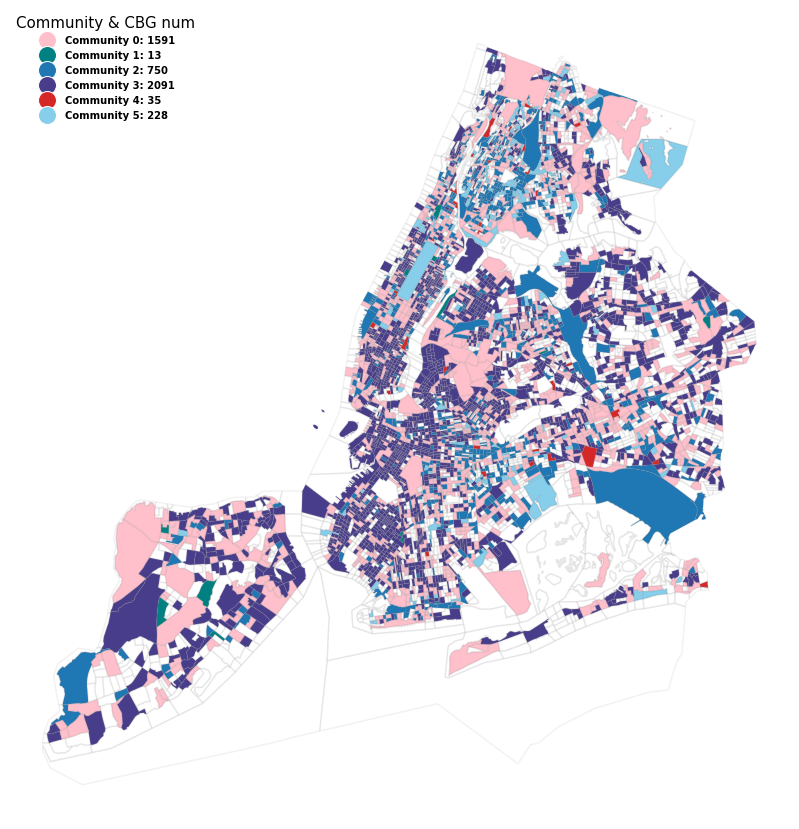

In [ ]:
visualizePartitionShape(cluster_geo, 'prediction', 'poi_cbg', 6)

In [ ]:
cluster_cbg.shape

(4708, 2)

In [ ]:
cbg.shape

(6493, 9)

### Try KMeans with day-of-week features

In [ ]:
weekly_and_core.select('visits_by_day').show(5)

+------------------+
|     visits_by_day|
+------------------+
|   [7,9,6,5,3,5,4]|
|  [3,5,7,4,6,13,3]|
|   [3,6,7,6,7,8,2]|
|   [6,5,7,8,5,6,8]|
|[4,6,14,24,8,10,9]|
+------------------+
only showing top 5 rows



In [ ]:
dayofweek.show(5)

+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     poi_cbg|        avg(day_0)|        avg(day_1)|        avg(day_2)|        avg(day_3)|        avg(day_4)|        avg(day_5)|        avg(day_6)|
+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|360850169012| 9.713797035347776|10.265678449258838|10.486887115165336|10.623717217787913| 10.70581527936146| 8.949828962371722| 7.179019384264538|
|360810838003| 7.502732240437158|  8.41712204007286| 8.247723132969035| 8.703096539162113| 9.579234972677595|11.191256830601093| 9.825136612021858|
|360470828001|11.870636550308008|12.236139630390143|12.362422997946611|12.851129363449692|14.367556468172484|14.949691991786448|11.562628336755647|
|360470224003| 5.368181818181818| 6.822727272727272|6.2727272727272725| 6.613636363636363| 6.009090909090909| 3.

In [ ]:
dayofweek.count()

4708

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

# feature columns to vector
vecAssembler = VectorAssembler(inputCols=["avg(day_%d)" % i for i in range(7)], 
                               outputCol="raw_features", handleInvalid='skip')

# crate normalizer
normalizer = MinMaxScaler(inputCol="raw_features", outputCol="features", 
                          min=0, max=1)

# create pipeline
pipeline_normalize = Pipeline(stages=[vecAssembler, normalizer])

# normalize data
day_features = pipeline_normalize.fit(dayofweek).transform(dayofweek).cache()

In [ ]:
day_features.select('poi_cbg', 'features').show(5, truncate=False)

In [ ]:
S_day = []
for i in range(2, 16):

    # Trains a k-means model.
    kmeans = KMeans().setK(i).setSeed(0000)
    model = kmeans.fit(day_features)

    # Make predictions
    predictions = model.transform(day_features)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    S_day.append(silhouette)
    print("K = %d, Silhouette score = %s" % (i, str(silhouette)))

K = 2, Silhouette score = 0.8461177127236823
K = 3, Silhouette score = 0.7634352931947676
K = 4, Silhouette score = 0.6950291141728234
K = 5, Silhouette score = 0.6931728197815327
K = 6, Silhouette score = 0.6335134163815253
K = 7, Silhouette score = 0.6356464339003455
K = 8, Silhouette score = 0.6438392081183311
K = 9, Silhouette score = 0.6019367198326336
K = 10, Silhouette score = 0.5851301945434808
K = 11, Silhouette score = 0.5701871970845697
K = 12, Silhouette score = 0.5741687345586468
K = 13, Silhouette score = 0.545005892211676
K = 14, Silhouette score = 0.521380426437488
K = 15, Silhouette score = 0.5173680620827106


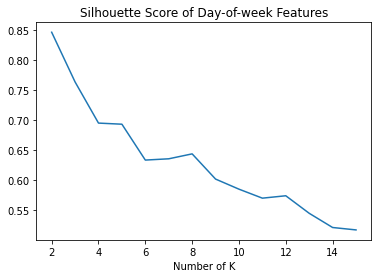

In [ ]:
plt.plot(range(2,16), S_day)
# plt.axvline(x=7, color='purple', ls='--')
plt.title('Silhouette Score of Day-of-week Features')
plt.xlabel('Number of K')
plt.show()

In [ ]:
from sklearn import preprocessing

dayofweek_pdf = dayofweek.toPandas().set_index('poi_cbg')
dayofweek_pdf.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# values = dayofweek_pdf.values 
# min_max_scaler = preprocessing.MinMaxScaler()
# values_scaled = min_max_scaler.fit_transform(values)
# dayofweek_normed = pd.DataFrame(values_scaled, index=dayofweek_pdf.index, 
#                                 columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# dayofweek_normed.head()

### All types of POI results

Based on the tries on hour-of-day and day-of-week scoring results, KMeans fits on the day-of-week featurs with K=7 have a relatively better performance. So, will choose day-of-week model and further analysis within each cluster.

In [ ]:
kmeans = KMeans().setK(7).setSeed(2021)
model = kmeans.fit(day_feature)

# Make predictions
predictions = model.transform(day_feature)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

In [ ]:
silhouette

0.8224813892082308

In [ ]:
predictions.show(5)

+------------+----------+----------+----------+----------+----------+----------+----------+--------------------+----------+
|     poi_cbg|sum(day_0)|sum(day_1)|sum(day_2)|sum(day_3)|sum(day_4)|sum(day_5)|sum(day_6)|            features|prediction|
+------------+----------+----------+----------+----------+----------+----------+----------+--------------------+----------+
|360050090001|     11459|     11658|     12491|     11829|     12048|      8013|      6198|[11459.0,11658.0,...|         0|
|360850169011|     21479|     22416|     23226|     22942|     22161|     15874|     12462|[21479.0,22416.0,...|         5|
|360810040012|      6503|      6484|      6809|      6773|      7856|      7379|      6560|[6503.0,6484.0,68...|         0|
|360850169012|     13433|     14767|     14265|     14497|     13862|     12427|     10419|[13433.0,14767.0,...|         0|
|360470349002|     10931|     10910|     11365|     11236|     12318|     11024|      8120|[10931.0,10910.0,...|         0|
+-------

### Day-of-week trends

In [ ]:
cluster_day = predictions.toPandas()
cluster_day = cluster_day.rename(columns=dict(zip(['sum(day_%d)'%i for i in range(7)], 
                                                  ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])))
cluster_day = cluster_day.drop(columns=['features'])
cluster_day.head()

,poi_cbg,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,prediction
0,360050090001,11459,11658,12491,11829,12048,8013,6198,0
1,360850169011,21479,22416,23226,22942,22161,15874,12462,5
2,360810040012,6503,6484,6809,6773,7856,7379,6560,0
3,360850169012,13433,14767,14265,14497,13862,12427,10419,0
4,360470349002,10931,10910,11365,11236,12318,11024,8120,0


In [ ]:
# groupby cluster labels
dayofweek_cluster = cluster_day.rename(columns={'prediction': 'Communities'})
dayofweek_cluster = dayofweek_cluster.groupby('Communities').mean()
dayofweek_cluster

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Communities,,,,,,,
0,5.767188e+03,5.992695e+03,6.168392e+03,6.194657e+03,6.460213e+03,5.734073e+03,4.937528e+03
1,7.488400e+05,7.213565e+05,7.574205e+05,8.050760e+05,8.193375e+05,5.670885e+05,5.947955e+05
2,3.764953e+05,3.998914e+05,4.133971e+05,4.163647e+05,4.203961e+05,3.339726e+05,2.562778e+05
3,1.210394e+06,1.154576e+06,1.195602e+06,1.265868e+06,1.259528e+06,1.155697e+06,1.206721e+06
4,1.693405e+05,1.806345e+05,1.870313e+05,1.868497e+05,1.852812e+05,1.414564e+05,1.120693e+05
5,2.373290e+04,2.486802e+04,2.556675e+04,2.561931e+04,2.623597e+04,2.179828e+04,1.779458e+04
6,7.301490e+04,7.686398e+04,7.879627e+04,7.933896e+04,8.069545e+04,6.735318e+04,5.432361e+04


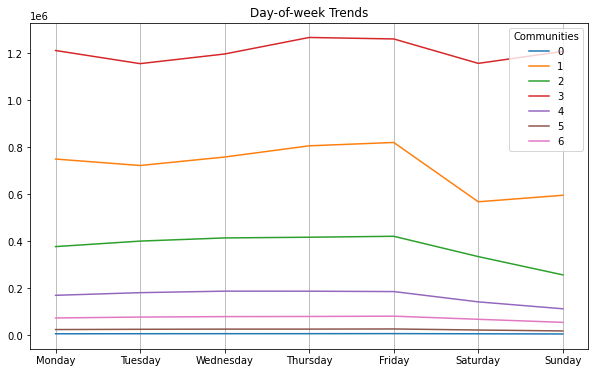

In [ ]:
dayofweek_cluster.T.plot(figsize=(10,6))
plt.title('Day-of-week Trends')
plt.grid(axis='x')
plt.show()

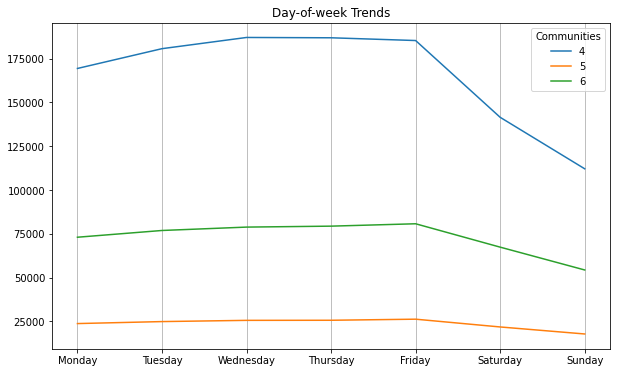

In [ ]:
dayofweek_cluster[4:].T.plot(figsize=(10,6))
plt.title('Day-of-week Trends')
plt.grid(axis='x')
plt.show()

In [ ]:
cluster_cbg = cluster_day[['poi_cbg', 'prediction']]
cluster_cbg = cluster_cbg.rename(columns={'prediction': 'Communities'})
cluster_cbg.shape

(6150, 2)

In [ ]:
# save cbg and label data
import csv
cluster_cbg.to_csv("/content/drive/MyDrive/Big Data/Data/cluster_cbg.csv", 
                        header=True, sep=',', quoting=csv.QUOTE_ALL, index=None)

### Hour-of-day trends

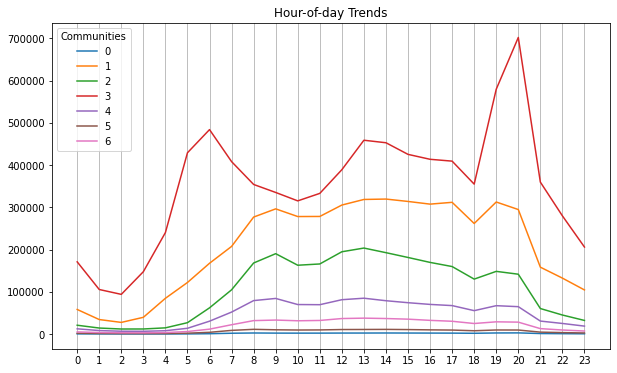

In [ ]:
hourofday_cluster.T.plot(figsize=(10,6))
plt.title('Hour-of-day Trends')
plt.xticks(range(24))
plt.grid(axis='x')
plt.show()

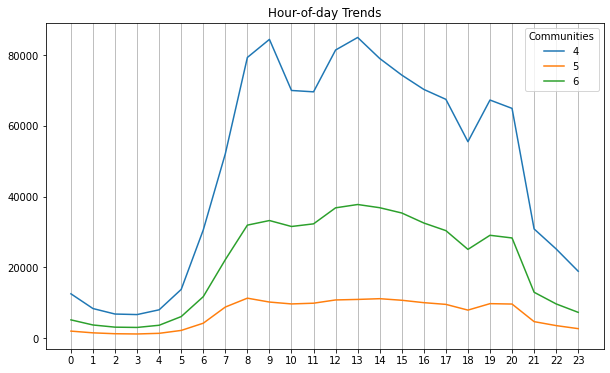

In [ ]:
hourofday_cluster[4:].T.plot(figsize=(10,6))
plt.title('Hour-of-day Trends')
plt.xticks(range(24))
plt.grid(axis='x')
plt.show()

### Median Dwell

In [ ]:
dwell = weekly_nyc.select(col("poi_cbg"), col("median_dwell").cast("integer").alias("median_dwell"))
dwell = dwell.groupby('poi_cbg').mean().toPandas()
dwell_cluster = dwell.merge(cluster_cbg, on='poi_cbg')
dwell_cluster = dwell_cluster.groupby('Communities').mean()
dwell_cluster

,avg(median_dwell)
Communities,
0,77.986359
1,70.556207
2,99.511885
3,54.045015
4,102.464427
5,76.848507
6,80.305677


Text(0.5, 1.0, 'Dwell Time')

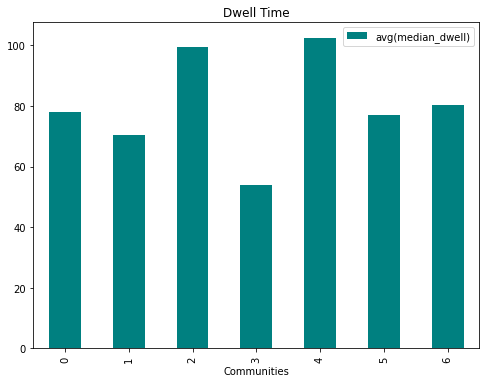

In [ ]:
dwell_cluster.plot.bar(figsize=(8,6), color='teal')
plt.title('Dwell Time')

### Distance from Home

In [ ]:
distance = weekly_nyc.select(col("poi_cbg"), col("distance_from_home").cast("integer").alias("distance_from_home"))
distance = distance.groupby('poi_cbg').mean().toPandas()
distance_cluster = distance.merge(cluster_cbg, on='poi_cbg')
distance_cluster = distance_cluster.groupby('Communities').mean()
distance_cluster

,avg(distance_from_home)
Communities,
0,5414.762181
1,108884.478325
2,30407.108347
3,29120.218445
4,38120.753349
5,8077.431172
6,19766.539924


Text(0.5, 1.0, 'Travel Distance')

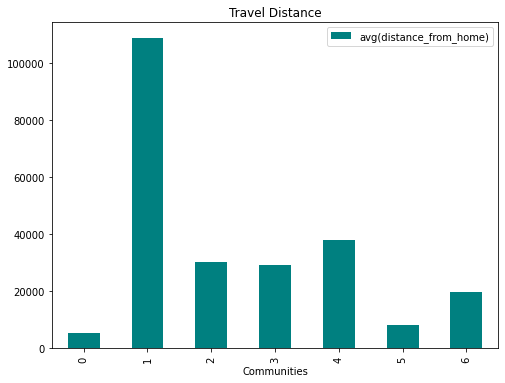

In [ ]:
distance_cluster.plot.bar(figsize=(8,6), color='teal')
plt.title('Travel Distance')

### Spatial Visualization

In [ ]:
cbg = gpd.read_file('/content/drive/MyDrive/Big Data/Data/nyc_cbgs.geojson')
cbg.head()

,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,MTFCC,geometry
0,36,005,017500,2,360050175002,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.91570 40.83054, -73.91485 ..."
1,36,005,014100,1,360050141001,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.91661 40.82499, -73.91592 ..."
2,36,005,014500,1,360050145001,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.90584 40.83106, -73.90505 ..."
3,36,005,007500,2,360050075002,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.91035 40.81995, -73.91022 ..."
4,36,005,041800,1,360050418001,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.86288 40.89515, -73.86146 ..."


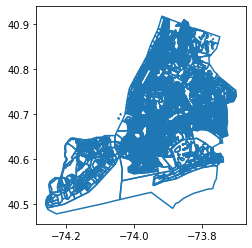

In [ ]:
cbg.geometry.boundary.plot()

In [ ]:
cluster_cbg = pd.read_csv("/content/drive/MyDrive/Big Data/Data/cluster_cbg.csv")
cluster_cbg.poi_cbg = cluster_cbg.poi_cbg.astype('str')
cluster_cbg.head()

,poi_cbg,Communities
0,360050090001,0
1,360850169011,5
2,360810040012,0
3,360850169012,0
4,360470349002,0


In [ ]:
count = cluster_cbg.groupby('Communities').count()
count

,poi_cbg
Communities,
0,5008
1,2
2,15
3,1
4,35
5,932
6,157


In [ ]:
cluster_geo = cluster_cbg.merge(cbg, left_on='poi_cbg', right_on='CensusBlockGroup', how='left')
cluster_geo = gpd.GeoDataFrame(cluster_geo)
cluster_geo.head(2)

,poi_cbg,Communities,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,MTFCC,geometry
0,360050090001,0,36,005,009000,1,360050090001,NY,Bronx County,G5030,"MULTIPOLYGON (((-73.84647 40.81231, -73.84610 ..."
1,360850169011,5,36,085,016901,1,360850169011,NY,Richmond County,G5030,"MULTIPOLYGON (((-74.12256 40.61308, -74.12140 ..."


In [ ]:
# function for visualizing communities
from matplotlib.lines import Line2D 

def visualizePartitionShape(gdf, label, field_id, plttitle = 'partition'):
    fig, ax =  plt.subplots(figsize=(15, 15))
    # cmap = plt.get_cmap(cmap_style)
    # colors = [cmap(i) for i in np.linspace(0, 1, 7)]
    colors=['darkslateblue', 'teal', 'tab:blue','tab:red','skyblue','pink','gold','tab:purple','gray','brown','seagreen','wheat']

    for c in range(7): # for each cluster
        # loc = gdf[][field_id].tolist() # add IDs of this cluster
        gdf.geometry.loc[gdf[label]==c].plot(color=colors[c], ax=ax)
    
    legend_elements = [Line2D([0], [0], color='w', marker='o', label='Community %d: %d'%(i, count.poi_cbg[i]), markersize=18, markerfacecolor=colors[i]) for i in range(7)]

    ax.set_axis_off()
    ax.legend(handles=legend_elements, title='Community & CBG num', title_fontsize=15, loc='upper left', fontsize=14, frameon=False, prop={'weight':'bold'}) #
    # plt.title(plttitle) 
    plt.show()

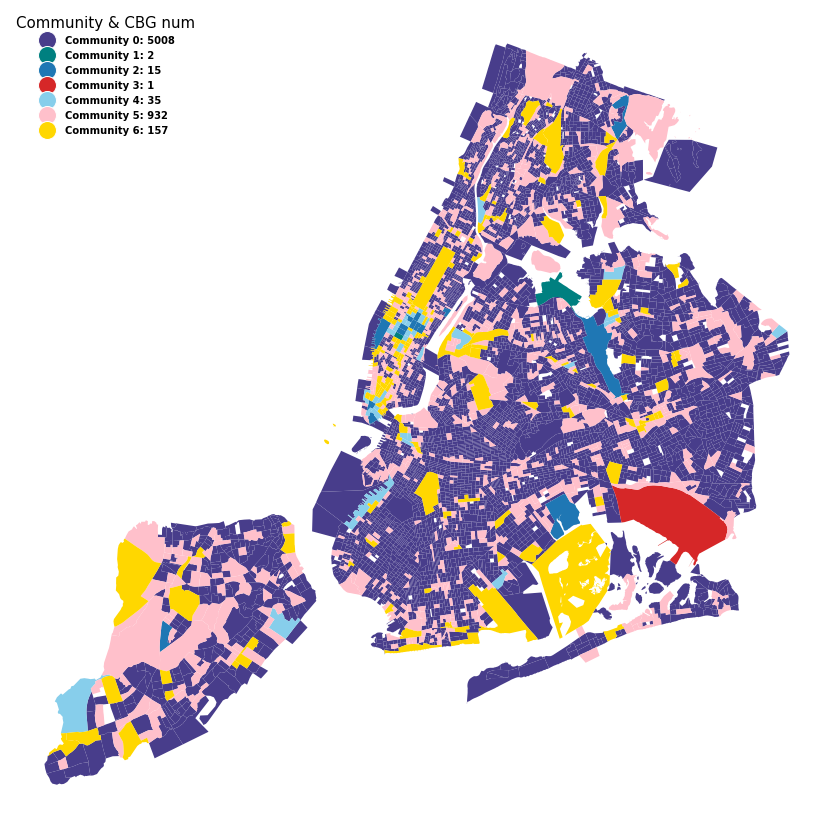

In [ ]:
visualizePartitionShape(cluster_geo, 'Communities', 'poi_cbg', plttitle = 'Community Detection')